In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Lecture 02

## Implementation of Perceptron

<img src='../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align = "left"/>

## 1. Import Statements

In [3]:
###-----------------
### Import Libraries
###-----------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import seaborn as sns

from sklearn import datasets
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
 
%matplotlib inline

## 2. Setup Global Parameters

In [4]:
###----------------
### Some parameters
###----------------

# Directory locations
inpDir = '../../input'
outDir = '../output'

RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed = RANDOM_STATE) # Set Random Seed for reproducible  results

NOISE = 0.2
EPOCHS = 4000  # number of epochs
ALPHA = 0.1  # learning rate
N_SAMPLES = 1000
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## 3. Generate Data Set
<div style="font-family: Arial; font-size:1.2em;color:black;">
Sklearn's dataset generator is good source of data for learning. To keep the example simple, I'll suggest  <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html">make_moon</a> dataset generator.
</div>

In [5]:
#Generate Dataset

X,y = datasets.make_moons(n_samples=N_SAMPLES, shuffle=True, noise=NOISE, random_state=RANDOM_STATE)

In [6]:
X.shape, y.shape

((1000, 2), (1000,))

## 4. Visualization
<p style="font-family: Arial; font-size:1.2em;color:black;">
DataFrames are easier to visualize
</p>

In [7]:
data_df = pd.DataFrame(X, columns=['A','B'])
data_df['target'] = y
data_df

,A,B,target
0,0.906340,0.902676,0
1,-1.115368,0.755793,0
2,1.887692,0.417597,1
3,-0.933450,-0.022999,0
4,-0.968729,0.063963,0
...,...,...,...
995,-1.005476,0.490728,0
996,-0.484457,0.846436,0
997,0.284856,0.793560,0
998,1.712514,-0.177786,1


In [8]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       1000 non-null   float64
 1   B       1000 non-null   float64
 2   target  1000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 23.6 KB


In [9]:
data_df.describe()

,A,B,target
count,1000.000000,1000.000000,1000.00000
mean,0.490841,0.239025,0.50000
std,0.898951,0.540082,0.50025
min,-1.688795,-0.955280,0.00000
25%,-0.149565,-0.205090,0.00000
50%,0.500100,0.241163,0.50000
75%,1.095048,0.680394,1.00000
max,2.419113,1.612075,1.00000


### 4.1 Different ways of plotting data

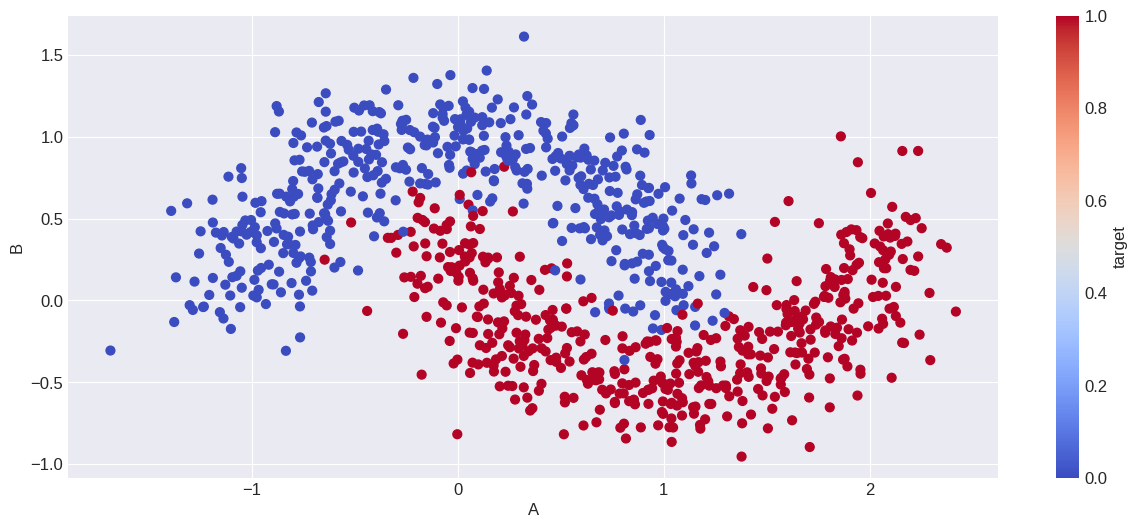

In [10]:
#Different ways of plotting data

data_df.plot.scatter('A','B', s=40, c='target', cmap=CMAP)
plt.show()

<Axes: xlabel='target'>

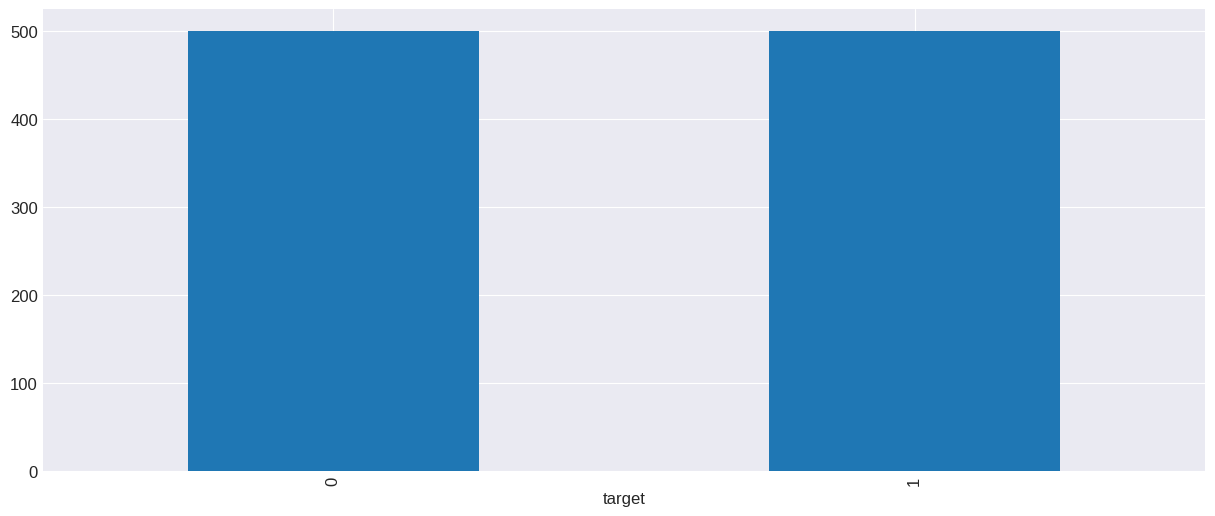

In [11]:
data_df['target'].value_counts().plot.bar()


<Axes: xlabel='A', ylabel='B'>

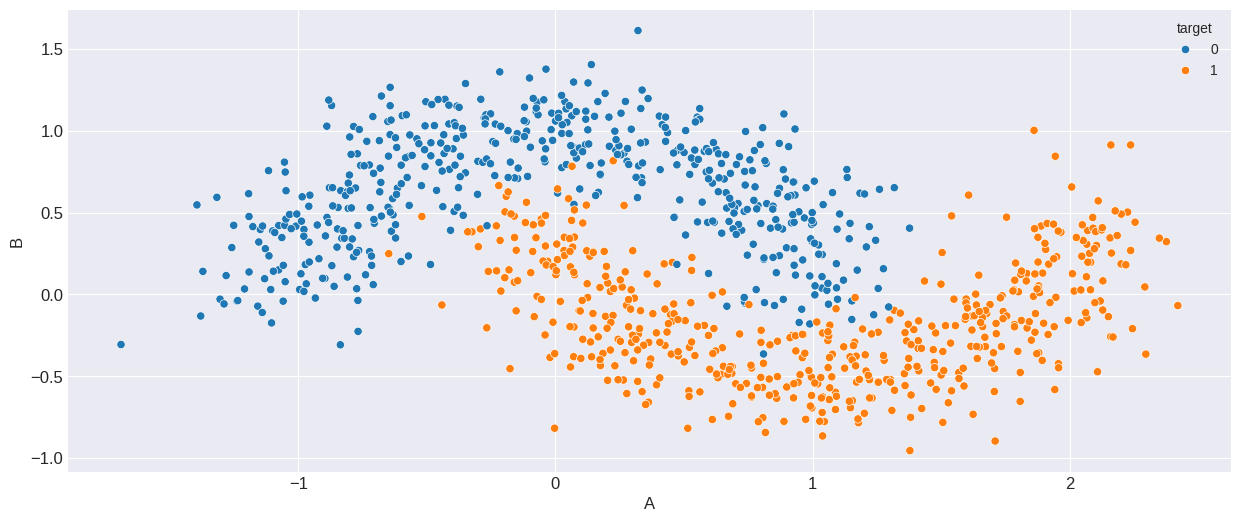

In [12]:
sns.scatterplot(x= 'A', y= 'B', data=data_df, hue='target')

In [13]:
#Splitting dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE)

In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 2), (200, 2), (800,), (200,))

<div style="font-family: Arial; font-size:1.2em;">
    We will keep 10%, i.e. 100 records for testing and remaining records will be used in training. Note that the data is already random.
</div>

# Over to Perceptron

<div style="font-family: Arial; font-size:1.1em;">

Our output is binary. To keep the code in line with what we discussed in the lecture, we will simply output 1 for positive values of 'z' and zero for negative values.
</div>

<img src="../../images/dnn_nb_s03_fig1.png" width='350' align = 'left'>


$$
\begin{aligned}
z & = 1.0 \circ w_0 + x_1 \circ w_1 + x_2 \circ w_2 \\
\mathrm{or}\\
z & = X\circ W \\
\end{aligned}
$$
<br/>


$$
\begin{equation*}
    \hat{y} = \begin{cases}
      1.0, & \text{for z>=0}\  \\
      0.0, & \text{for z<0}\
    \end{cases}
\end{equation*}
$$

<div style="font-family: Arial; font-size:1.2em;">
<p>
As we know that adjustments in the weights are (a-$\hat{y}$). We don't want to adjust by full value. It makes convergence easier if we adjust by a small fraction. </p>
    <p><b>Why?</b> We would know better all through this module. We will circle back to learning_rate after some sessions.
<p>Let's assume that adjusting weights by $\alpha$ * ( a - $\hat{y}$ ) makes better sense. </p>
<p>
    <strong>Note:</strong> Take learning_rate ($\alpha$) as some constant.
</p>
</div>

## Sigmoid function

In [15]:
def fn_sigmoid(z):
    return 1/(1+np.exp(-z))

In [16]:
fn_sigmoid(np.array([-np.inf , 0 , 0.5 , 1, np.inf]))

array([0.        , 0.5       , 0.62245933, 0.73105858, 1.        ])

In [17]:
def fn_tanh(z):
    return np.tanh(z)

def fn_active_prime(a):
    return 1 - np.tanh(a)**2

## 5. Prediction

In [18]:
#A function to make prediciton 

def predict(model, X):
    
    w1, b1, w2, b2= model['w1'], model['b1'], model['w2'], model['b2']

    ## Forward Propagation

    ##Layer 1
    z1 = X.dot(w1)+b1 ##Agg
    a1= fn_tanh(z1)  ##Activation

    ##Layer 2
    z2 = X.dot(w2)+b2 ##Agg
    a2= fn_sigmoid(z2)  ##Activation
    
    return a2 >= 0.5

**Its advisable to test the function**

In [19]:
#Unit test
weights = np.array([0.1, 2.0, 1.0])

display(data_df.loc[0])

predict(data_df.loc[0].values, weights)

A         0.906340
B         0.902676
target    0.000000
Name: 0, dtype: float64

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

<div style="font-family: Arial; font-size:1.2em;">
    <h3>Back-propagation - Estimate Perceptron weights </h3>
    $
\begin{aligned}
\partial{z}  & = a - y \\
\partial{b}  & = \partial{z} \\
\partial{w_1}  & = x_1 \circ \partial{z}\\
\partial{w_2}  & = x_2 \circ \partial{z}\\
\end{aligned}
$
    <hr>
      $
\begin{aligned}
b & = b -  \frac{1}{m} (\alpha \circ \partial{b}) \\
w_1  & = w_1 - \frac{1}{m}(\alpha \circ \partial{w_1} )\\
w_2  & = w_2 - \frac{1}{m}(\alpha \circ \partial{w_2} )\\
\end{aligned}
$
    </div>
    
 ## 6. Training

In [ ]:
def calculate_loss(model, X, y):

    w1, b1, w2, b2= model['w1'], model['b1'], model['w2'], model['b2']

    m = X.shape[0]
    ## Forward Propagation

    ##Layer 1
    z1 = X.dot(w1)+b1 ##Agg
    a1= fn_tanh(z1)  ##Activation

    ##Layer 2
    z2 = X.dot(w2)+b2 ##Agg
    a2= fn_sigmoid(z2)  ##Activation

    data_loss = -(y*np.log(a2)).sum()

    return 1./m * data_loss

In [ ]:
y_train = y_train.reshape(-1,1)

y_train.shape

(800, 1)

In [ ]:
# Function to train the model
#Function to train the model

def build_model(X, y,alpha=ALPHA, epochs=EPOCHS):
    errors = []

    w1 = np.random.rand(nn_input_dim, nn_hdim)/np.sqrt(nn_input_dim)
    w2 = np.random.rand(nn_hdim, nn_output_dim)/np.sqrt(nn_hdim)

    b1 = np.zeros((1, nn_hdim))
    b2 = np.zeros((1, nn_output_dim))

    curr_loss = 0

    loss, epoch = [], []

    m = X.shape[0]

    for i in range(epochs):

        ## Forward Propagation

        ##Layer 1
        z1 = X.dot(w1)+b1 ##Agg
        a1= fn_tanh(z1)  ##Activation

        ##Layer 2
        z2 = a1.dot(w2)+b2 ##Agg
        a2= fn_sigmoid(z2)  ##Activation

        ## Backward Propagation

        ##Layer 1
        dz2 = a2 -y
        assert(z2.shape == dz2.shape), f'error z2 {z2.shape}/{dz2.shape}'

        dw2 = a1.T.dot(dz2)
        assert(w2.shape == dw2.shape), f'error w2 {w2.shape}/{dw2.shape}'

        db2 = np.sum(dz2,  axis=0, keepdims=True)
        assert(b2.shape == db2.shape), f'error b2 {b2.shape}/{db2.shape}'

        
        da1 = dz2.dot(w2.T)
        
        ##Layer 1
        dz1 = da1 * fn_active_prime(z1)

        dw1 = (X.T).dot(dz1)
        assert(w1.shape == dw1.shape), f'error w1 {w1.shape}/{dw1.shape}'

        db1 = np.sum(dz1,  axis=0, keepdims=True)
        assert(b1.shape == db1.shape), f'error b1 {b1.shape}/{db1.shape}'

        w1 += -alpha * dw1/ m #Gradient update

        w2 += -alpha * dw2/ m #Gradient update

        b1 += -alpha * db1/ m #Gradient update

        b2 += -alpha * db2/ m #Gradient update

        model = {'w1':w1, 'b1':b1, 'w2':w2, 'b2':b2}

        if i %100 == 0:
            curr_loss= calculate_loss(model, X, y)
            loss.append(curr_loss)
            epoch.append(i)

    return model

In [ ]:
nn_input_dim = X_train.shape[1]
nn_hdim= 4
nn_output_dim = 1

In [ ]:
y_train = y_train.reshape(-1,1)
y_train.shape

(800, 1)

In [ ]:
# calling 'train_weight'

model = build_model(X_train, y_train)

print(weights)

ValueError: shapes (800,2) and (4,1) not aligned: 2 (dim 1) != 4 (dim 0)

NameError: name 'errors' is not defined

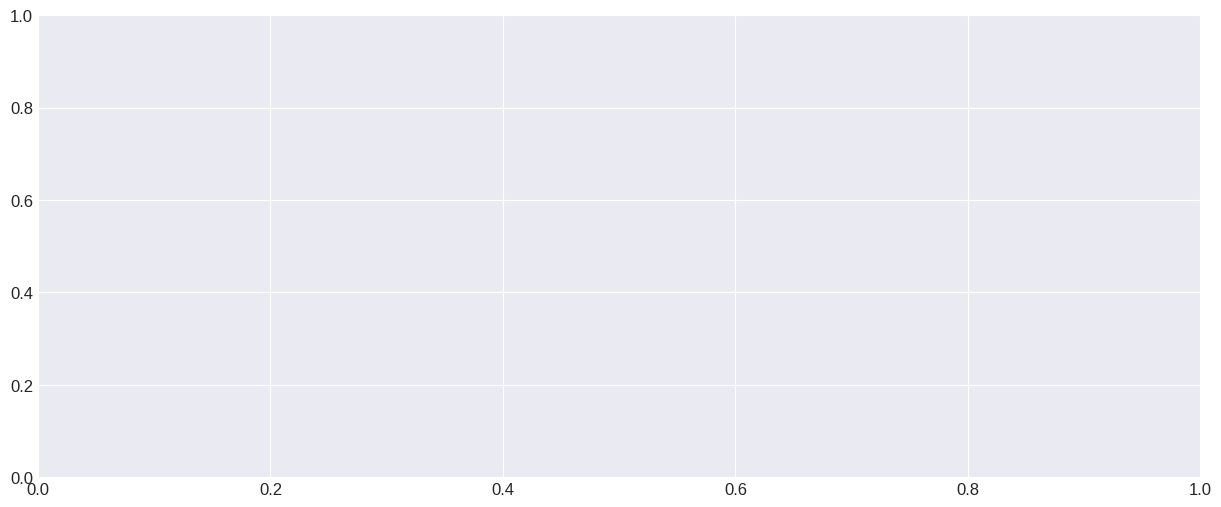

In [ ]:
fig, ax= plt.subplots()
ax.plot(errors)

## Question
<div style="font-family: Arial; font-size:1.2em;">
Why do we keep training and not stop at min training error? Hold on! We would get to that eventually.
</div>

## 7. Predictions

### Train Set

In [ ]:
predictions = []

for row in data_train:  #iterate over all rows
    prediction = predict(row , weights) # make prediction

    if prediction > 0.5:
        y_pred = 1
    else:
        y_pred = 0

        
    predictions.append(y_pred) #collect them in a list

In [ ]:
accuracy_score(data_train[: , -1] , predictions) #calculating accuracy

0.8655555555555555

### Test Set

In [ ]:
predictions = []

for row in data_test:  #iterate over all rows
    prediction = predict(row , weights) # make prediction

    if prediction > 0.5:
        y_pred = 1
    else:
        y_pred = 0

        
    predictions.append(y_pred) #collect them in a list

In [ ]:
accuracy_score(data_test[: , -1] , predictions) #calculating accuracy

0.9

In [ ]:
cm =  confusion_matrix(data_test[:,-1],predictions) #calculati accuracy
cm

array([[55,  3],
       [ 7, 35]])

<Figure size 600x600 with 0 Axes>

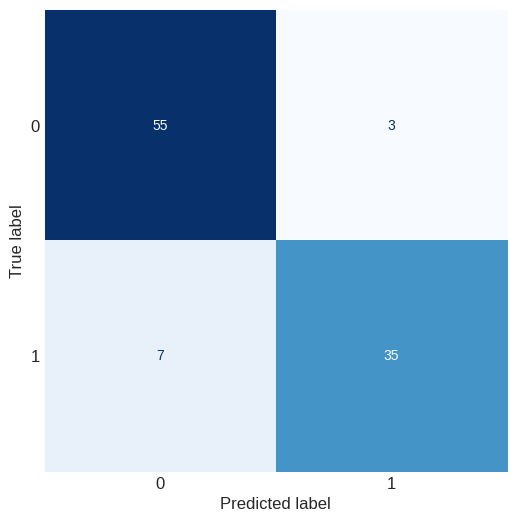

In [ ]:
fig.ax = plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm , display_labels=[0,1])
disp.plot(cmap = "Blues" , colorbar=False)
plt.grid()



In [ ]:
def fn_plot_decision_boundary(X_tr : np.ndarray, X_ts : np.ndarray , wtd : np.ndarray = weights):
    fig.ax = plt.subplots()
    dm = 0.5 

    x_min, x_max = X_tr[:,0].min() - 0.5 , X_tr[: , 0].max() + 0.5
    y_min, y_max = X_tr[:,0].min() - 0.5 , X_tr[: , 0].max() + 0.5
    

    xx  , yy = np.meshgrid(np.arange(x_min , x_max , dm), np.arange(y_min ,y_max , dm))

    XX = np.c_[xx.ravel() , yy.ravel()]

    XX = np.hstack((XX , np.ones((XX.shape[0],1))))

    y_pred =[]


    for row in (xx):

        a = fn_predict(row, wtd) 
        y_p = 0

    if a >= 0.5 : y_p = 1

    y_pred.append(y_p)


Z = np.array(y_pred).reshape(xx.shape)


#plotting cotaours for data as per testing 
ax.contour(xx , yy , Z , aplha =0 , cmap=plt.cm.Paired)


#ploting scatter for test data
ax.scatter(X_ts[:,0],X_tr[:,1],c=X_tr[:,2],s=30 , edgecolor= "k" , cmap=plt.cm.coolwarm)


IndentationError: expected an indented block after 'for' statement on line 18 (3122470518.py, line 20)

## Tracking
<div style="font-family: Arial; font-size:1.2em;color:black;">
Lets track the results across various implementations...

 |#|Implementation|Training Accuracy|Testing Accuracy|Remarks|
 |:-:|---|---|---|---|
 |1|Simple Perceptron|0.83111|0.89000||

## Notes:
<img src="../../images/dnn_nb_s03_fig1.png" width='350' align = 'left'>
<img src="../../images/dnn_nb_s03_fig2.png" width='550' align = 'right'>

## A note on Loss Function
<div style="font-family: Arial; font-size:1.2em;">
    <p>In logistic regression we are looking for if it is correct class or not. </p> 
    <p>For example, we want to know if there is a car in the picture or not. So the output is probability of a car in the picture.</p>
    <p><b>Mathematically speaking:</b></p>
    <p>$\hat{y} = p(y=1|x)$ i.e. given training sample $x$, we want to know probability of $y$ being 1.</p>
    <br>
    <p><b>Alternatively:</b></p>
    <p>If there is a car in the picture.  $\Rightarrow$  $y$ = 1 then $p(y|x)$ = $\hat{y}$.</p>
    <p>If there is <b>no</b> car in the picture.$\Rightarrow$ $y$ = 0 then $p(y|x)$ = 1 - $\hat{y}$.</p>
    <br>
    <p>We can summarize two equations as: $p(y|x)$ = $\hat{y}^{y} * (1 - \hat{y}) ^{(1-y)}$</p>
    <p>Above equation is $\hat{y}$ for y = 1 and (1 - $\hat{y}$) for y = 0.</p>
    <p>Taking log of above equation:</p>

$
\begin{aligned}
log [ p(y|x) ] & = log[\hat{y}^{y} * (1 - \hat{y}) ^{(1-y)}]\\
& = y * log(\hat{y}) + (1-y) * log(1 - \hat{y})\\
\end{aligned}
$
<p>Since we aim to minimize above function, add negative sign and our loss function becomes</p>

$
\begin{aligned}
L(\hat{y},y) =  -[y * log\hat{y} + (1-y) * log(1-\hat{y})]\\
\text{or}\\
L(a,y) =  - [ y * log ( a ) + ( 1 - y ) * log( 1 - a ) ]\\
\end{aligned}
$

|Case| y |Loss| a |-log(a)|-log(1-a)|
|:-: |:-:|:-: |:-:|  :-: |   :-:  |
| 1  | 0 | -log( 1 - a )| 0.000001 |13.8155|**1 e-6**|
| 2  | 0 | -log( 1 - a )| 0.999999 |1 e-6|**13.8155**|
| 3  | 1 | -log( a )| 0.000001 |**13.8155**|1 e-6|
| 4  | 1 | -log( a )| 0.999999 |**1 e-6**|13.8155|

</div>

<div style="font-family: Arial; font-size:1.2em;">
    <p>For binary classification the error = - $y * log(a)$</p>
    <p>We want to sum it up for all samples in the dataset. Hence:</p>

$
\begin{aligned}
p(\text{all ys | all rows of x}) & =  \Pi_{i=0}^m p(y|x)\\
log [ p(\text{all ys | all rows of x})] & =  log [ \Pi_{i=0}^m p(y|x) ]\\
& =  \sum_{i=0}^m log [ p(y|x) ] \\
& =  \sum_{i=0}^m [ y * log(\hat{y}) + (1-y) * log(1 - \hat{y}) ]\\
\text{Divide it by m to better scale the costs}\\
& = \frac{1}{m} * \sum_{i=0}^m [ y * log(\hat{y}) + (1-y) * log(1 - \hat{y}) ]\\
\end{aligned}
$

### Introducing $\mathrm{sigmoid}$ function for our binary output.
$$
\begin{aligned}
z & = x_1 . w_1 + x_2 . w_2 + b_1 \\
a & = \hat{y} = \sigma(z)\\
dz & = (a - y) \\
db & = dz\\
b & = b - \alpha . db\\
dw_1 & = x_1. dz\\
dw_2 & = x_2.dz\\
w_1 & = w_1 - \alpha . dw_1\\
w_2 & = w_1 - \alpha . dw_2\\
\end{aligned}
$$
### Sigmoid function
$$
\begin{align}
a &= \sigma(z)\\
&= \dfrac{1}{1 + e^{-z}}\\
\end{align}
$$
    <h3>Derivative of sigmoid function</h3>
$$
\begin{align}
\partial{a} &= \partial{(\sigma(z))}\\
&= \dfrac{\partial}{\partial{z}} \left[ \dfrac{1}{1 + e^{-z}} \right] \\
&= \dfrac{\partial}{\partial{z}} \left( 1 + \mathrm{e}^{-z} \right)^{-1} \\
&= -(1 + e^{-z})^{-2}(-e^{-z}) \\
&= \dfrac{e^{-z}}{\left(1 + e^{-z}\right)^2} \\
&= \dfrac{1}{1 + e^{-z}\ } \circ \dfrac{e^{-z}}{1 + e^{-z}}  \\
&= \dfrac{1}{1 + e^{-z}\ } \circ \dfrac{(1 + e^{-z}) - 1}{1 + e^{-z}}  \\
&= \dfrac{1}{1 + e^{-z}\ } \circ \left[ \dfrac{1 + e^{-z}}{1 + e^{-z}} - \dfrac{1}{1 + e^{-z}} \right] \\
&= \dfrac{1}{1 + e^{-z}\ } \circ \left[ 1 - \dfrac{1}{1 + e^{-z}} \right] \\
&= \sigma(z) \circ (1 - \sigma(z))\\
&= a \circ (1 - a)
\end{align}
$$
    </div>